# Text Classification with BERT in Pytorch

@description: It is a Python3 file to implement text classification with BERT in Pytorch.

@author: Yantong Lai

@date: 01/14/2020

## 0. Install transformers

In [1]:
! pip3 install transformers

In [2]:
import transformers

transformers.__version__

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

'2.3.0'

## 1. Data Pre-processing

### 1.1 Configure CPU

In [3]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

### 1.2 Read dataset file

We use the Yelp provided polarity dataset for text classification. You could download the Yelp polarity dataset via [link](https://www.kaggle.com/irustandi/yelp-review-polarity/version/1#test.csv) in Kaggle.

In [4]:
import pandas as pd
import numpy as np

train_filename = "yelp_review_polarity_csv/train.csv"
test_filename = "yelp_review_polarity_csv/test.csv"

df_train = pd.read_csv(train_filename, header=None, names=['label', 'text'])
df_test = pd.read_csv(test_filename, header=None, names=['label', 'text'])

Take a look at the train data and test data.

In [5]:
df_train.head()

,label,text
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


In [6]:
df_test.head()

,label,text
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."
3,1,The food is good. Unfortunately the service is...
4,2,Even when we didn't have a car Filene's Baseme...


Sample 10 items which label is 1.

In [7]:
df_train.loc[df_train.label == 1].sample(10)

,label,text
269164,1,"Reading the other reviews, I think we must hav..."
23975,1,"If you want pizza, go anywhere else, anywhere!..."
31799,1,I scheduled an appointment and no one showed u...
266851,1,"I'm a bit of a sushi snob, so when I heard tha..."
156393,1,So I took my parents here during Christmas Day...
211913,1,The only reason I keep going back to this loca...
211693,1,"This is not a terrible place, but it's far fro..."
187305,1,NOT THE LEAST BIT AUTHENTIC!!!!\n\nI can't get...
269394,1,I went here recently for lunch. I had the Kung...
53115,1,"Once again, I came back and gave this place an..."


### 1.3 Get the values of DataFrame

In [8]:
train_labels = df_train['label'].tolist()
train_text = df_train['text'].tolist()

test_labels = df_test['label'].tolist()
test_text = df_test['text'].tolist()

assert len(train_labels) == len(train_text)
assert len(test_labels) == len(test_text)

print("len(train_text) = {}, len(test_text) = {}".format(len(train_text), len(test_text)))

len(train_text) = 560000, len(test_text) = 38000


### 1.4 Get values indices

The label in the dataset is `1` and `2`. When training in BERT, we should format the label to `0` and `1`.

In [9]:
def format_label_value(label_list):
    """
    It is a function to format label.
    """
    format_label_list = []

    for label in label_list:
        format_label_list.append(label - 1)
    
    return format_label_list

We just wanna learn BERT in the text classification task on our own computer, with the limitation of memory, we need to get the indices of dataset.

**Orig**:
- len(train_text) = 560000
- len(test_text) = 38000

**Indice according to the ratio `0.001`**:
- len(train_text) = 560
- len(test_text) = 38

In [10]:
train_labels, train_text = train_labels[:560], train_text[:560]
test_labels, test_text = test_labels[:38], test_text[:38]

train_labels = format_label_value(train_labels)
test_labels = format_label_value(test_labels)

## 2. BERT Tokenization & Input Formatting

### 2.1 BERT Tokenization

In [11]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


**Let's apply the tokenizer to one sentence just to see the output.**

In [12]:
# Print the original sentence.
print('Original: ', train_text[0])
print("len(Original) = ", len(train_text[0]))
print("\n")

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_text[0]))
print("len(Tokenized) = ", len(tokenizer.tokenize(train_text[0])))
print("\n")

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_text[0])))
print("len(Token IDs) = ", len(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_text[0]))))
print("\n")

Original:  Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars.
len(Original) =  643


Tokenized:  ['unfortunately', ',', 'the', 'frustration', 'of', 'being', 'dr', '.', 'goldberg', "'", 's', 'patient', 'is', 'a', 'repeat', 'of', 'the', 'experience', 'i', "'", 've', 'had', 'with', 'so', 'many', 'other', 'doctors', 'in', 'nyc', '-', '-', 'good', 'doctor', ',', 'terrible', 'staff', '.', 'it', 'seems', 'that'

### 2.2 Input Formatting for BERT

**BERT needs adding special tokens --- [cls] and [sep]**

The `tokenizer.encode` function combines multiple steps for us:
1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.

Oddly, this function can perform truncating for us, but doesn't handle padding. 

**Encoding for text in training dataset**

In [13]:
import logging

# Set logger to avoid warning `token indices sequence length is longer than the specified maximum sequence length for this model (1017 > 512)`
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)


def text_to_id(tokenizer, text_list):
    """
    It is a function to transform text to id.
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    """
    ids_list = []
    
    for item in text_list:
        # Sentence to id and add [CLS] and [SEP]
        encoded_item = tokenizer.encode(item, add_special_tokens=True)
        ids_list.append(encoded_item)
    
    return ids_list

In [14]:
train_text_ids = text_to_id(tokenizer, train_text)
test_text_ids = text_to_id(tokenizer, test_text)


# Print sentence 0, now as a list of IDs.
print('Original: {}\n'.format(train_text[0]))
print('Token IDs: {}\n'.format(train_text_ids[0]))
print("len(train_text_ids) = {}\n".format(len(train_text_ids)))
print("len(test_text_ids) = {}".format(len(test_text_ids)))

Original: Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars.

Token IDs: [101, 6854, 1010, 1996, 9135, 1997, 2108, 2852, 1012, 18522, 1005, 1055, 5776, 2003, 1037, 9377, 1997, 1996, 3325, 1045, 1005, 2310, 2018, 2007, 2061, 2116, 2060, 7435, 1999, 16392, 1011, 1011, 2204, 3460, 1010, 6659, 3095, 1012, 2009, 3849, 2008, 2010, 3095, 3432, 2196, 6998, 1996, 3042, 1012, 2009, 2788, 3138, 1016, 2847, 1997, 55

**Calculate the maximum length of train_text_ids**

In [15]:
print('Train: max sentence length: ', max([len(sen) for sen in train_text_ids]))
print('Train: Min sentence length: ', min([len(sen) for sen in train_text_ids]))
print('Test: max sentence length: ', max([len(sen) for sen in test_text_ids]))
print('Test: Min sentence length: ', min([len(sen) for sen in test_text_ids]))

Train: max sentence length:  1019
Train: Min sentence length:  3
Test: max sentence length:  661
Test: Min sentence length:  20


From above results, we could find that the length of each sentence in `train_text_ids` is not the same, so we need to pad or truncate the text ids.

### 2.3 Padding & Truncating

In [16]:
def padding_truncating(input_ids_list, max_length):
    """
    It is a function to perform padding and truncating
    @param input_ids_list: <List> text_ids
    @param max_length: <Integer> the number we wanna the sentence to be padding or truncating
    @return: processed input_ids_list
    """
    processed_input_ids_list = []
    for item in input_ids_list:
        seq_list = []
        
        if len(item) < max_length:
            # Define a seq_list with the length of max_length
            seq_list = [0] * (max_length - len(item))
            item = item + seq_list
        
        elif len(item) >= max_length:
            item = item[:max_length]
            
        processed_input_ids_list.append(item)
    
    return processed_input_ids_list

**Padding or truncating the `train_text_ids` and `test_text_ids`**

In [17]:
train_padding_list = padding_truncating(train_text_ids, max_length=50)
test_padding_list = padding_truncating(test_text_ids, max_length=50)

### 2.4 Attention Masks

The attention mask simply makes it explicit which tokens are actual words versus which are padding. The `BERT` vocabulary does not use the ID 0, so **if a token ID is 0, it's a padded one, and otherwise it's a real token**.

In [18]:
def get_attention_masks(pad_input_ids_list):
    """
    It is a function to get attention masks:
    
    - If a token ID is 0, then it's padding, set the mask to 0.
    - If a token ID is > 0, then it's a real token, set the mask to 1.
    """
    attention_masks_list = []
    
    for item in pad_input_ids_list:
        
        mask_list = []
        for subitem in item:
            if subitem > 0:
                mask_list.append(1)
            else:
                mask_list.append(0)
        attention_masks_list.append(mask_list)
    
    return attention_masks_list

In [19]:
train_attention_masks = get_attention_masks(train_padding_list)
test_attention_masks = get_attention_masks(test_padding_list)

assert len(train_text) == len(train_labels) == len(train_attention_masks) == len(train_padding_list)
assert len(test_text) == len(test_labels) == len(test_attention_masks) == len(test_padding_list)

### 2.5 Split train dataset into train_dataset and validation_dataset

In [20]:
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_padding_list, validation_padding_list, train_labels, validation_labels, train_attention_masks, validation_attention_masks = train_test_split(train_padding_list, train_labels, train_attention_masks, random_state=2020, test_size=0.1)

In [21]:
assert len(train_labels) == len(train_attention_masks) == len(train_padding_list)
assert len(validation_labels) == len(validation_attention_masks) == len(validation_padding_list)
assert len(test_labels) == len(test_attention_masks) == len(test_padding_list)

In [22]:
print("len(train_labels) = {}\nlen(validation_labels) = {}\nlen(test_labels) = {}".format(len(train_labels), len(validation_labels), len(test_labels)))

len(train_labels) = 504
len(validation_labels) = 56
len(test_labels) = 38


### 2.6 Convert to Dataset

#### 2.6.1 Convert all the `List` objects to tensor

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Convert all inputs and labels into torch tensors, the required datatype for our model.
train_inputs = torch.tensor(train_padding_list)
validation_inputs = torch.tensor(validation_padding_list)
test_inputs = torch.tensor(test_padding_list)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_attention_masks)
validation_masks = torch.tensor(validation_attention_masks)
test_masks = torch.tensor(test_attention_masks)

#### 2.6.2 Form the Dataset with torch.tensor

In [24]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## 3. Train BERT Text Classification Model

### 3.1 BertForSequenceClassification

**Load `BertForSequenceClassification` from `transformers`**

In [25]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
import torch

# Load BertForSequenceClassification, the pretrained BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",  # Use the 12-layer BERT model, with an uncased vocab.
     num_labels = 2,      # The number of output labels -- 2 for binary classification.
                    # You can increase this for multi-class tasks.   
     output_attentions = False, # Whether the model returns attentions weights.
     output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### 3.2 Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values:
- Batch size: 16, 32  (We chose 32 when creating our DataLoaders).
- Learning rate (Adam): 5e-5, 3e-5, 2e-5  (We'll use 2e-5).
- Number of epochs: 2, 3, 4  (We'll use 4).

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [26]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )



In [27]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
print("total_steps = {}".format(total_steps))

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

total_steps = 128


### 3.3 Train

In [28]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [29]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [30]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 12345

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(epochs):
    
    ##########################################
    #               Training                 #
    ##########################################
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 10 batches.
        if step % 10 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear the gradients.
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we have provided the `labels`.
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end. 
        # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        total_loss += loss.item()

        # Perform a `backward` pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
        
    ##########################################
    #               Validation               #
    ##########################################
    # After the completion of each training epoch, measure our performance on our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to device
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            # token_type_ids is the same as the "segment ids", which differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        # flat_accuracy(y_pred, y_true)
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    10  of     32.    Elapsed: 0:00:46.
  Batch    20  of     32.    Elapsed: 0:01:38.
  Batch    30  of     32.    Elapsed: 0:02:26.

  Average training loss: 0.60
  Training epcoh took: 0:02:34

Running Validation...
  Accuracy: 0.86
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    10  of     32.    Elapsed: 0:00:46.
  Batch    20  of     32.    Elapsed: 0:01:31.
  Batch    30  of     32.    Elapsed: 0:02:15.

  Average training loss: 0.31
  Training epcoh took: 0:02:22

Running Validation...
  Accuracy: 0.86
  Validation took: 0:00:03

======== Epoch 3 / 4 ========
Training...
  Batch    10  of     32.    Elapsed: 0:00:45.
  Batch    20  of     32.    Elapsed: 0:01:29.
  Batch    30  of     32.    Elapsed: 0:02:12.

  Average training loss: 0.12
  Training epcoh took: 0:02:20

Running Validation...
  Accuracy: 0.86
  Validation took: 0:00:03

======== Epoch 4 / 4 ========
Training...
  Batch    10  of 

### 3.4 Plot

**Plot the average loss in training**

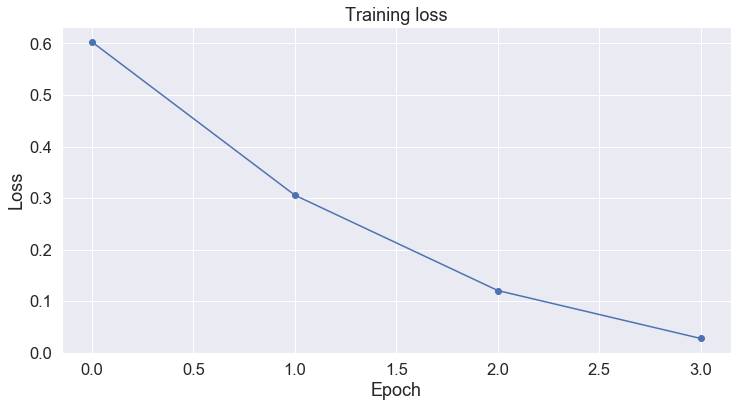

In [35]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

### 3.5 Evaluation

In [32]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
idx = 0
correct = 0
for batch in test_dataloader:
    
    print("Batch {}".format(idx + 1))
    idx += 1
    
    # Add batch to device
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    # Get the prediction probability
    logits = outputs[0]
    
    # Get the prediction label
    pred = np.argmax(logits, axis=1)
   
    # Get the total correct number between pred and true labels in each batch
    correct += (pred == b_labels).sum().item()
    print("correct = {}\n".format(correct))
    

print('DONE.')
print("Total correct = ", correct)
print("Test accuracy = {0:.2f}".format(correct / len(test_inputs)))

Predicting labels for 38 test sentences...
Batch 1
correct = 14

Batch 2
correct = 28

Batch 3
correct = 31

DONE.
Total correct =  31
Test accuracy = 0.82


### 3.6 Saving Trained Model

In [33]:
import os

saved_model_dir = "./saved_models/"

if not os.path.exists(saved_model_dir):
    os.makedirs(saved_model_dir)

# Save model to the saved_model_dir
model.save_pretrained(saved_model_dir)
tokenizer.save_pretrained(saved_model_dir)

('./saved_models/vocab.txt',
 './saved_models/special_tokens_map.json',
 './saved_models/added_tokens.json')

### 3.7 Load Trained Model

In [34]:
# Load a trained model and vocabulary that you have fine-tuned

# Model_class: BertForSequenceClassification, XLNetForSequenceClassification, XLMForSequenceClassification, RobertaForSequenceClassification
load_model = BertForSequenceClassification.from_pretrained(saved_model_dir)       

# Tokenizer_class: BertTokenizer, XLNetTokenizer, XLMTokenizer, RobertaTokenizer
load_tokenizer = BertTokenizer.from_pretrained(saved_model_dir)